<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0304_MNIST%2CF1%2CROC%2C%EB%8B%A4%EC%A4%91%EC%B6%9C%EB%A0%A5%EB%B6%84%EB%A5%98_HandsOnML_127_154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류
## 3-1. MNIST (데이터셋)
- 학습용으로 자주 사용되는 데이터샛
- 사이킷런에서 제공하는 헬퍼 함수를 사용해 다운받을 수 있다


In [3]:
# MNIST 데이터셋을 다운받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 사이킷런에서 읽어들인 데이터셋들은 일반적으로 딕셔너리 구조를 가지고 있다

In [4]:
X,y= mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


- 70000개의 이미지와 784개의 feature 가 있다. feature는 이미지가 28X28 개 있으므로 784개이다. 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.
- 데이터셋에서 이미지 1개를 확인해보자. 샘플의 특성 벡터를 추출하여 29X28배열로 크기를 바꾸고 맷플롯립의 imshow()함수를 사용해 그리면 된다.

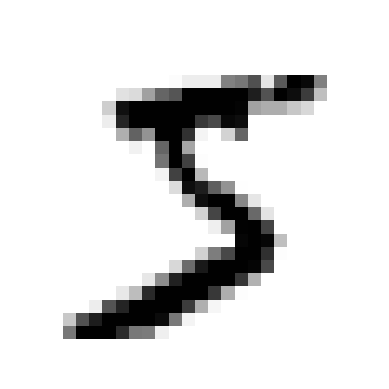

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]  # X데이터셋에서 첫 row의 데이터
some_digit_image = some_digit.reshape(28,28) # 28X28의 array로 배열

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

- 이 그림은 숫자 5로 보인다. 실제 레이블을 확인해보자

In [6]:
y[0]

'5'

- 레이블은 문자열(Char)이다. 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y(target)을 정수로 변환한다.

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## 3.2 이진 분류기 훈련
- 문제를 단순화하여 숫자 5와 숫자 5가 아닌 수, 두가지로 분류되는 분류기를 만들어 숫자 5만 식별해보도록 한다.

In [9]:
y_train_5 = (y_train == 5)  # 5는 true이고 나머지는 모두 False
y_test_5 = (y_test == 5)

- 이제 분류 모델을 하나 선택하여 훈련시켜본다. 사이킷런의 SGDClassifier 클래스를 사용해 **확률적 경사하강법(SGD)** 분류기로 시작해본다. 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있다. SGD는 한번에 한 훈련 샘플을 독립적으로 처리하기 때문이다 (이 때문에 SGD는 온라인 학습에 잘 들어맞는다).
- SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련해보겠다.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

- 이제 이 모델을 이용해 숫자 5의 이미지를 감지해본다
- SGDClassifier는 훈련하는 데 무작위성을 사용한다. 결과를 재현하고 싶다면 random_state 매개변수를 지정해야 한다.

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정
- 성능측정에 사용할 수 있는 성능지표는 다양하다

### 3.3.1 교차 검증을 사용한 정확도 측정
- 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다. 이 때는 교차검증 기능을 직접 구현하면 된다. 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # 클래스별 비율이 유지되도록 데이터를 분할하는 교차 검증을 수행하기 위한 Scikit-Learn의 모듈

for train_index, test_index in skfolds.split(X_train,y_train_5):
  clone_clf = clone(sgd_clf) # 분류기를 복제합니다. 이것은 각 폴드에 대해 분류기를 새로 훈련하기 위한 것입니다.
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) # 0.95035, 0.96035, 0.9604 가 출력된다

0.95035
0.96035
0.9604


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행합니다. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듭니다. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력합니다.





- 이제, cross_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier모델의 평가해보겠다. k-겹 교차 검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억해라.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상이다.
- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보자

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도가 90% 이상으로 나온다.
- 이미지의 10% 정도가 숫자 5이므로 무조건 5 아님으로 예측하면 정확히 맞출 확률이 90% 이다.
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이류를 보여준다. 특히 **불균형한 데이터셋**을 다룰 때 더욱 그렇다

### 3.3.2. 오차 행렬
- 분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**을 조사하는 것이다.
- 오차행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안된다. 대신 cross_vla_predict()함수를 사용할 수 있다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3)

- cross_val_score()함수처럼 cross_val_predict()함수는 k-겹 교차검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 즉, 훈련세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.(여기서 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미이다.)
-이제, confusion_matrix() 함수를 사용해 오차행렬을 만들자

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 **행은 실제 클래스**를 나타내고 **열은 예측한 클래스**를 나타낸다.

In [20]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도(precision) : 양성 예측의 정확도. TP/(TP+FP)
- 재현율(recall)=민감도(sensitivity)=진짜 양성 비율(TPR) : 분류기가 정확하게 감지한 양성 샘플의 비율. TP/(TP+FN)
- TP: 진양성
- FP: 위양성
- FN: 위음성

### 3.3.3 정밀도와 재현율

In [22]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
recall_score(y_train_5,y_train_pred)

0.8370879772350012


0.6511713705958311

- F1 score : 정밀도와 재현율의 조화평균
- F1 =2*(정밀도x재현율)/(정밀도+재현율)

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높다. 이는 항상 바람직한 것은 아니다
- 정밀도-재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지인것

### 3.3.4 정밀도-재현율 트레이드오프
- SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보자. 이 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산한다.


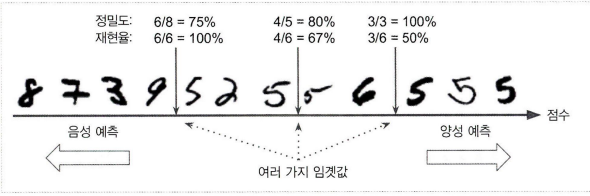

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [28]:
threshold=8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

- 이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다. 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만 임곗값을 8000으로 높이면 이를 놓치게 된다.
- 그렇다면 적절한 임곗값을 어떻게 정할 수 있을까? 이를 위해서는 먼저 cross_val_predict() 함수를 사용해 훈련세트에 있는 모든 샘플의 점수를 구해야 한다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 한다.

In [29]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5, cv=3, method ="decision_function")

- 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

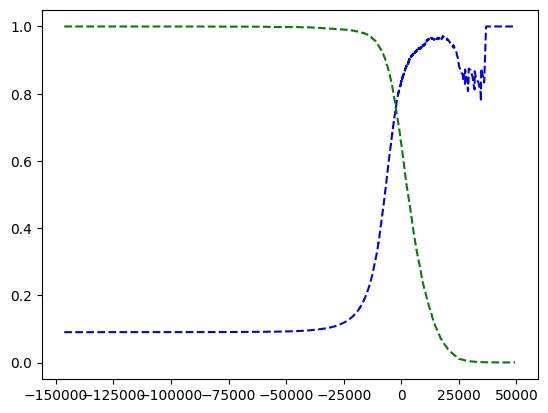

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g--", label="정밀도")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 좋은 정밀도-재현율 트레이드오프를 선택하는 방법은 그림처럼 재현율에 대한 정밀도 곡선을 그리는 것이다.

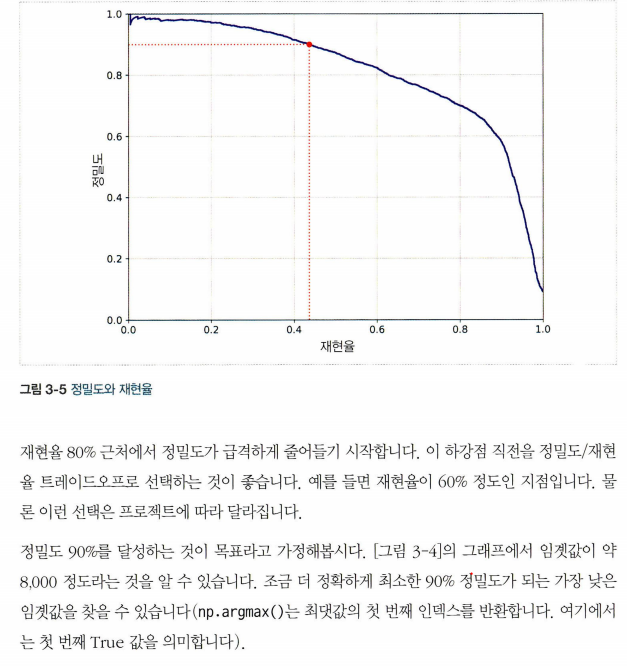

- 훈련 세트에 대한 예측을 만들려면 분류기의 predict()메서드를 호출하는 대신 다음 코드를 실행하면 된다.

### 3.3.5 ROC 곡선
수신기 조작 특성(ROC) 곡선도 이진 분류에서 널리 사용하는 도구이다. 거짓양성비율(FPR)에 대한 진짜양성비율(TPR).

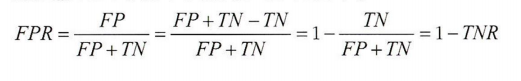

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

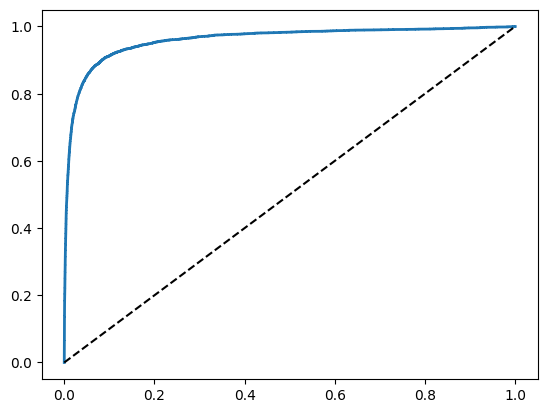

In [35]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2, label=label)
  plt.plot([0,1],[0,1],"k--")  # 대각 점선

plot_roc_curve(fpr,tpr)
plt.show()

- 여기서도 트레이드오프가 있다. TPR이 증가할수록 FPR이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 의미한다.
- 좋은 분류기는 이 곡선에서 최대한 멀리 떨어져 있어야 한다.
- 곡선 아래의 면적(AUC:Area Under Curve)을 통헤 분류기들을 비교할 수 있다. 완벽한 분류기의 ROC의 AUC는 1이다.

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용합니다
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

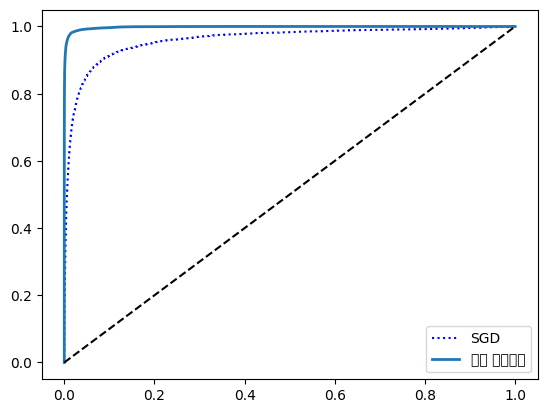

In [40]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

- RandomForestClassifier의 ROC곡선이 SGDClassifier보다 왼쪽 모서리에 더 가깝다
- RandomForestClassifier의 ROC곡선이 SGDClassifier보다 ROC AUC 점수가 1에 더 가깝다

## 3.4 다중 분류
- 이진 분류가 두개의 클래스를 구별하는 반면 다중 분류기(또는 다항 분류기)는 둘 이상의 클래스를 구별할 수 있다


In [42]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [86]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

- 가장 높은 점수가 클래스 5에 해당하는 값이다

In [ ]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
svm_clf.classes_[5]

- 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장한다.
- 위 예제에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같지만, 일반적으로 이런 경우는 드물다.
---
- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier를 사용한다. 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 된다. 예를 들어 다음 코드는 SVC기반으로 OvR전략을 사용하는 다중 분류기를 만든다.

In [44]:
from sklearn.multiclass import OneVsOneClassifier
ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train,y_train)
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

[5]


45

- SGDClassifier(또는 RandomForestClassifier)를 훈련시키는 것도 간단하다

In [45]:
sdg_clf.fit(X_train,y_train)
sdg_clf.predict([some_digit])

NameError: name 'sdg_clf' is not defined

- 이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없다. decision_function()메서드는 클래스마다 하나의 값을 반환한다. SGD 분류기가 클래스마다 부여한 점수를 확인해보자

In [ ]:
sgd_clf.decision_function([some_digit])

- 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있다. 대부분의 점수가 큰 음수이다. 반면 클래스 5의 점수는 2412.5이다. 이 모델은 573.5 의 점수를 얻은 클래스 3을 조금 의심하고 있다.

- 이제 분류기를 평가해본다. 분류기 평가에는 일반적으로 교차 검증을 사용한다.
- cross_val_score를 통해 SGDClassifier의 정확도를 평가해보자

In [46]:
cross_val_score(sgd_clf, X_train,y_train,cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 모든 테스트 폴드에서 84% 이상을 얻었습니다. 랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로 이 점수가 아주 나쁘지는 않지만 성능을 더 높일 여지가 있다.
- 간단하게 입력의 스케일 조정으로 정확도를 89% 이상으로 높일 수 있다

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train,cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [48]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

- matshow() 함수를 사용해 이미지로 표현하면 보기 편하다

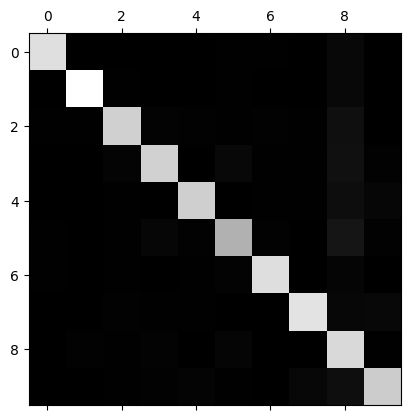

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 그래프의 에러 부분에 초점을 맞춰본다. 먼저, 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어(에러의 절대 개수가 아니라) 에러 비율을 비교한다. (개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보인다.)

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims= True)
norm_conf_mx = conf_mx/row_sums

- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그린다.

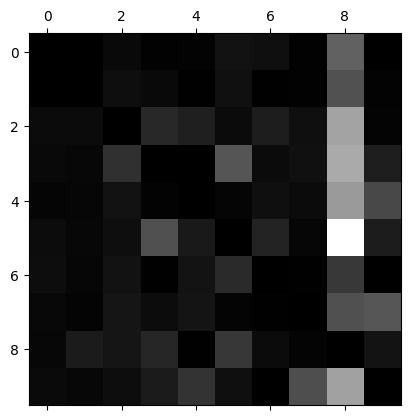

In [51]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

- 여기서는 분류기가 만든 에러를 확실히 볼 수 있다. 행은 실제 클래스를 나타내고 열은 예측 클래스를 나타낸다.
- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.
- 3과 5가 서로 많이 혼동됨을 알 수 있다.
- 예를 들어 3과 5의 샘플을 그려보자

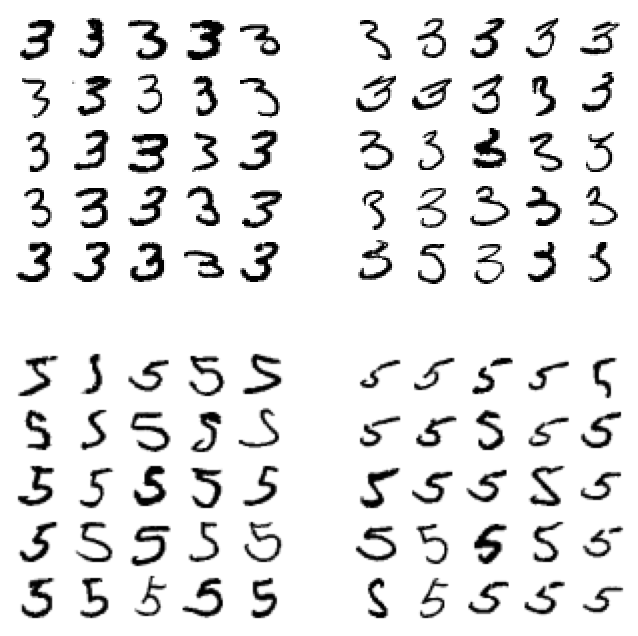

In [53]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

########################
def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
    rimages = images[row * images_per_row : (row + 1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap = plt.cm.binary, **options)
  plt.axis("off")
########################


plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽의 5x5블록 2개는 3으로 분류된 이미지이다.
- 오른쪽 5x5블록 2개는 5로 분류된 이미지이다.
- 분류기는 이미지의 위치나 회전 방향에 매우 민감하다. 3과 5의 에러를 줄이는 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것이다.

## 3.6 다중 레이블 분류
- 지금까지는 각 샘플이 하나의 클래스에만 할당되었다. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 하는 경우도 있다. 이를 다중 분류 시스템이라고 한다.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

- 이 코드는 각 숫자 이미지에 두개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다. 첫번째는 숫자가 큰 값(7,8,9)인지 나타내고 두번째는 홀수인지 나타낸다.
- KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다. 이제 예측을 하면 레이블이 2개 출력된다.

In [55]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 숫자 5는 크지 않고(False) 홀수이다.(True)

In [56]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 실제로는 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것이다.
- 해당 클래스에 속하는 데이터 수가 더 많을수록 더 높은 가중치를 둔다.
- 간단한 방법은 클래스의 지지도(support)를 가중치로 주는 것이다. 이렇게 하려면 average="weight"으로 설정하면 된다.

## 3.7 다중 출력 분류
- 다중 충력 다중 클래스 분류(다중 출력 분류)는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.
- 이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어본다. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열으로 출력한다. 분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러 개 가진다(0~255 픽셀 강도).
- 픽셀강도예측은 분류보다 회귀와 비슷하다. 다중출력시스템이 분류작업에 국한되지도 않는다. 그래서 샘플마다 클래스와 값을 모두 포함하는 다중 레이블이 출력되는 시스템도 가능하다

- train,test 데이터셋에 randint()함수를 사용해 픽셀 강도에 잡음을 추가한다. 타깃 이미지는 원본 이미지가 된다.

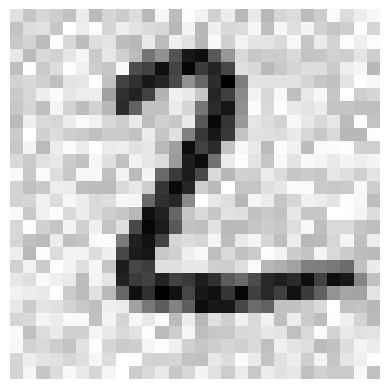

In [82]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mode = X_test

some_index=1
plot_digits([X_test_mod[some_index]],images_per_row=28)

- 위는 노이즈가 추가된 test 데이터이다

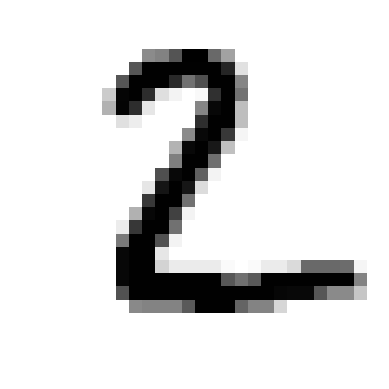

In [83]:
some_index=1
plot_digits([X_test[some_index]],images_per_row=28)

- 위는 노이즈가 추가되기 전 test 데이터이다

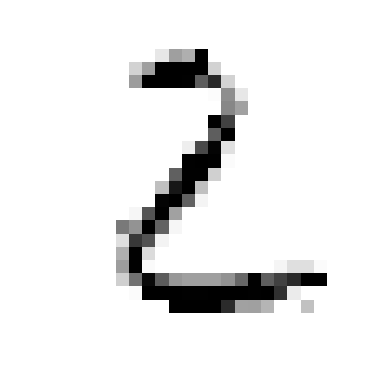

In [80]:
some_index=1
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

- 분류기를 훈련시켜 이미지를 깨끗하게 만들었다.
- 타깃과 비슷하게 구현됨을 알 수 있다